In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
from IPython.display import display, HTML

In [17]:
torch.cuda.empty_cache()

In [18]:
def load_yolo_model():
    model = YOLO('yolov8n.pt')
    return model

In [19]:
def process_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Check if the video opened successfully
    if not cap.isOpened():
        raise IOError(f"Cannot open video file: {video_path}")
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video dimensions: {width}x{height}")
    print(f"FPS: {fps}")
    print(f"Total frames: {total_frames}")
    
    return cap, total_frames, fps, width, height

In [20]:
def detect_people(model, frame):
    # Perform detection
    results = model(frame)
    
    # Filter for only person class (class 0 in COCO dataset)
    person_detections = []
    
    for result in results:
        boxes = result.boxes
        for i, box in enumerate(boxes):
            cls = int(box.cls[0].item())
            # Class 0 is 'person' in COCO dataset
            if cls == 0:
                # Get bounding box coordinates (x1, y1, x2, y2)
                x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                # Get confidence score
                conf = box.conf[0].item()
                person_detections.append((x1, y1, x2, y2, conf))
    
    return person_detections

In [21]:
def select_person_to_track(video_path, model):
    # Open the video
    cap = cv2.VideoCapture(video_path)
    
    # Read the first frame
    for i in range(100):  # Skip to frame 100 for better person visibility
        ret, frame = cap.read()
        if not ret:
            break
    
    # Detect people in the frame
    people = detect_people(model, frame)
    
    # Display the frame with detected people
    frame_with_boxes = frame.copy()
    for i, (x1, y1, x2, y2, conf) in enumerate(people):
        # Draw bounding box
        cv2.rectangle(frame_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Add person ID
        cv2.putText(frame_with_boxes, f"Person {i}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    # Convert to RGB for display
    frame_with_boxes = cv2.cvtColor(frame_with_boxes, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(frame_with_boxes)
    plt.title("Detected People - Note the ID of the person you want to track")
    plt.axis('off')
    plt.show()
    
    # Ask user to select a person by ID
    person_id = int(input("Enter the ID of the person you want to track: "))
    
    if person_id < 0 or person_id >= len(people):
        raise ValueError("Invalid person ID selected")
    
    cap.release()
    
    return person_id, people[person_id]

In [22]:
def calculate_center(bbox):
    x1, y1, x2, y2, _ = bbox
    center_x = int((x1 + x2) / 2)
    center_y = int((y1 + y2) / 2)
    return (center_x, center_y)

In [30]:
def track_person(video_path, model, initial_person_id, initial_bbox):
    cap = cv2.VideoCapture(video_path)
    route_points = []
    
    # Add the initial center point
    initial_center = calculate_center(initial_bbox)
    route_points.append(initial_center)
    
    # Initialize tracking parameters
    prev_center = initial_center
    prev_bbox = initial_bbox[:4]  # x1, y1, x2, y2
    
    frame_count = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        frame_count += 1
        if frame_count % 10 == 0:
            print(f"==> Processing frame {frame_count}/{total_frames} ({frame_count/total_frames*100:.1f}%)")
        
        # Detect all people in the current frame
        people = detect_people(model, frame)
        
        if people:
            # Find the best match for our tracked person
            best_match = None
            min_distance = float('inf')
            
            for bbox in people:
                x1, y1, x2, y2, conf = bbox
                center = calculate_center(bbox)
                
                # And distance between centers
                distance = np.sqrt((center[0] - prev_center[0])**2 + (center[1] - prev_center[1])**2)
                
                # Simple tracking based on closest center point
                if distance < min_distance:
                    min_distance = distance
                    best_match = bbox
            
            # If we found a match and it's reasonably close
            if best_match is not None and min_distance < 50:  # Threshold distance
                # Update previous center and bbox
                prev_center = calculate_center(best_match)
                prev_bbox = best_match[:4]
                
                # Add the center point to the route
                route_points.append(prev_center)
    
    cap.release()
    return route_points

In [31]:
def visualize_route(video_path, route_points, output_path, model):
    # Open the original video
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Process each frame
    frame_count = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        frame_count += 1
        if frame_count % 30 == 0:
            print(f"Creating output video: frame {frame_count}/{total_frames} ({frame_count/total_frames*100:.1f}%)")
        
        # Calculate corresponding route index
        route_frame_ratio = len(route_points) / total_frames
        route_index = min(int(frame_count * route_frame_ratio) - 1, len(route_points) - 1)
        route_index = max(0, route_index)
        
        # Draw the route as a thick red line
        for i in range(1, route_index + 1):
            cv2.line(frame, route_points[i-1], route_points[i], (0, 0, 255), 5)
        
        # Add bounding box around the tracked person
        if route_index >= 0:
            # Detect people in current frame
            people = detect_people(model, frame)
            
            if people:
                # Find the closest person to our tracked point
                current_center = route_points[route_index]
                best_match = None
                min_distance = float('inf')
                
                for bbox in people:
                    person_center = calculate_center(bbox)
                    distance = np.sqrt((person_center[0] - current_center[0])**2 + 
                                       (person_center[1] - current_center[1])**2)
                    
                    if distance < min_distance:
                        min_distance = distance
                        best_match = bbox
                
                # Draw bounding box for the tracked person if found and reasonably close
                if best_match is not None and min_distance < 100:
                    x1, y1, x2, y2, conf = best_match
                    # Draw a more visible bounding box (green with thickness 3)
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
                    # Add label
                    cv2.putText(frame, f"Tracked Person ({conf:.2f})", (x1, y1-10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
        # Write the frame to the output video
        out.write(frame)
    
    # Release resources
    cap.release()
    out.release()
    
    print(f"Output video saved to: {output_path}")
    return output_path

In [32]:
def main(input_video_path):
    """
    Main function to run the person route tracking process
    
    Args:
        input_video_path: Path to the input video file
    """
    # 1. Load the YOLO model
    print("Loading YOLO model...")
    model = load_yolo_model()
    
    # 2. Process the video to get basic information
    print("\nProcessing video...")
    cap, total_frames, fps, width, height = process_video(input_video_path)
    cap.release()
    
    # 3. Select the person to track
    print("\nSelecting person to track...")
    initial_person_id, initial_bbox = select_person_to_track(input_video_path, model)
    print(f"Selected person ID: {initial_person_id}")
    
    # 4. Track the selected person throughout the video
    print("\nTracking person...")
    route_points = track_person(input_video_path, model, initial_person_id, initial_bbox)
    print(f"Tracking complete. Collected {len(route_points)} route points.")
    
    # 5. Visualize the route on the video
    print("\nCreating output video with route visualization...")
    output_video_path = "output_tracked_route.mp4"
    visualize_route(input_video_path, route_points, output_video_path, model)
    
    return output_video_path

Loading YOLO model...

Processing video...
Video dimensions: 848x478
FPS: 30.01286880655807
Total frames: 2092

Selecting person to track...

0: 384x640 4 persons, 1 car, 45.4ms
Speed: 3.1ms preprocess, 45.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


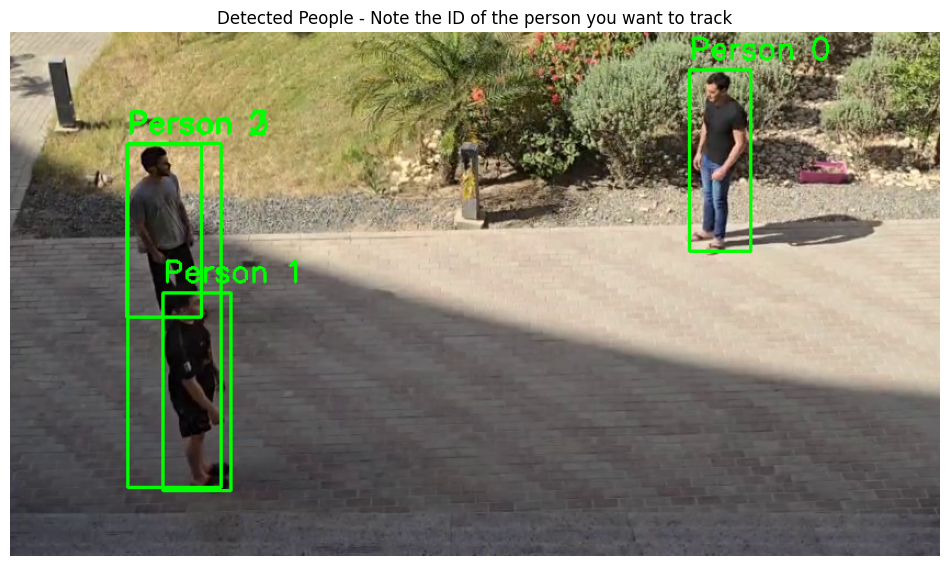

Enter the ID of the person you want to track:  1


Selected person ID: 1

Tracking person...

0: 384x640 2 persons, 97.6ms
Speed: 4.3ms preprocess, 97.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 9.4ms
Speed: 24.3ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 9.0ms
Speed: 1.9ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 8.6ms
Speed: 1.8ms preprocess, 8.6ms inference, 2.0ms

In [33]:
output_video = main("WhatsApp Video 2025-05-10 at 16.40.40_74eca27b.mp4")